In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, confusion_matrix
import csv
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV


In [2]:
df=pd.read_csv('assignment-1-data.csv')
data=df.to_numpy()

training_set = data[:2058]
validation_set = data[2058:2499]
test_set = data[2499:]

In [3]:
class DecisionTree:
    def __init__(self, max_depth=8):
        self.max_depth = max_depth
        self.root = None

    def fit1(self, X, y):
        y = np.asarray(y)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Check stopping criteria
        if depth >= self.max_depth or n_labels == 1 or n_samples <= 1:
            return {'label': Counter(y).most_common(1)[0][0], 'count': n_samples}

        best_gini = np.inf
        best_index = None
        best_value = None

        # Find the best split
        for feature_index in range(n_features):
            feature_values = np.unique(X[:, feature_index])
            for value in feature_values:
                left_indices = np.where(X[:, feature_index] <= value)[0]
                right_indices = np.where(X[:, feature_index] > value)[0]

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                gini = self._gini_impurity(y[left_indices], y[right_indices])
                if gini < best_gini:
                    best_gini = gini
                    best_index = feature_index
                    best_value = value

        if best_gini == np.inf:
            return {'label': Counter(y).most_common(1)[0][0], 'count': n_samples}

        # Split and grow the subtrees
        left_indices = np.where(X[:, best_index] <= best_value)[0]
        right_indices = np.where(X[:, best_index] > best_value)[0]
        left_tree = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._grow_tree(X[right_indices], y[right_indices], depth + 1)
        return {'feature_index': best_index, 'threshold': best_value, 'left': left_tree, 'right': right_tree}

    def _gini_impurity(self, left_y, right_y):
        def gini(y):
            m = len(y)
            return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

        m = len(left_y) + len(right_y)
        gini_left = gini(left_y)
        gini_right = gini(right_y)
        return (len(left_y) / m) * gini_left + (len(right_y) / m) * gini_right

    def predict(self, X):
        predictions = [self._traverse_tree(x, self.root) for x in X]
        return np.array(predictions)

    def _traverse_tree(self, x, node):
        if 'label' in node:
            return node['label']
        if x[node['feature_index']] <= node['threshold']:
            return self._traverse_tree(x, node['left'])
        else:
            return self._traverse_tree(x, node['right'])


In [4]:
class DecisionTreeRegressor:
    def __init__(self, min_samples_split=2, max_depth=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _ssr(self, y):
        mean_y = np.mean(y)
        ssr = np.sum((y - mean_y) ** 2)
        return ssr

    def _variance_reduction(self, parent, left_child, right_child):
        weight_left = len(left_child) / len(parent)
        weight_right = len(right_child) / len(parent)
        ssr_parent = self._ssr(parent)
        ssr_left = self._ssr(left_child)
        ssr_right = self._ssr(right_child)
        variance_reduction = ssr_parent - (weight_left * ssr_left + weight_right * ssr_right)
        return variance_reduction

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if n_samples >= self.min_samples_split and (self.max_depth is None or depth < self.max_depth):
            best_split = self._get_best_split(X, y, n_features)
            if best_split and best_split["variance_reduction"] > 0:
                left_tree = self._grow_tree(X[best_split["left_indices"]], y[best_split["left_indices"]], depth + 1)
                right_tree = self._grow_tree(X[best_split["right_indices"]], y[best_split["right_indices"]], depth + 1)
                return {"feature_index": best_split["feature_index"], "threshold": best_split["threshold"],
                        "left": left_tree, "right": right_tree}
        return {"value": np.mean(y)}

    def _get_best_split(self, X, y, n_features):
        best_split = None
        best_variance_reduction = -np.inf
        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_indices = np.where(X[:, feature_index] <= threshold)[0]
                right_indices = np.where(X[:, feature_index] > threshold)[0]
                if len(left_indices) > 0 and len(right_indices) > 0:
                    variance_reduction = self._variance_reduction(y, y[left_indices], y[right_indices])
                    if variance_reduction > best_variance_reduction:
                        best_variance_reduction = variance_reduction
                        best_split = {
                            "feature_index": feature_index, 
                            "threshold": threshold,
                            "left_indices": left_indices, 
                            "right_indices": right_indices,
                            "variance_reduction": variance_reduction
                        }
        return best_split

    def predict(self, X):
        return np.array([self._predict(inputs, self.tree) for inputs in X])

    def _predict(self, inputs, tree):
        if "value" in tree:
            return tree["value"]
        feature_index = tree["feature_index"]
        threshold = tree["threshold"]
        if inputs[feature_index] <= threshold:
            return self._predict(inputs, tree["left"])
        else:
            return self._predict(inputs, tree["right"])

class RandomForestRegressor:
    def __init__(self, n_estimators=100, min_samples_split=2, max_depth=None):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples = X.shape[0]
        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            sample_X, sample_y = X[indices], y[indices]
            tree = DecisionTreeRegressor(min_samples_split=self.min_samples_split, max_depth=self.max_depth)
            tree.fit(sample_X, sample_y)
            self.trees.append(tree)

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(tree_predictions, axis=0)

In [5]:
class RandomForestClassifier:
    def __init__(self, n_estimators=50, max_depth=8, max_features=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.estimators = []
    
    def fit(self, X, y): 
        self.estimators = []
        n_samples, n_features = X.shape

        if self.max_features is None:
            self.max_features = int(np.sqrt(n_features))

        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[indices]
            y_sample = y[indices]

            # Randomly select features for each tree
            selected_features = np.random.choice(n_features, self.max_features, replace=False)
            X_subset = X_sample[:, selected_features]

            # Create and fit a decision tree
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit1(X_subset, y_sample)
            self.estimators.append((tree, selected_features))

    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.zeros((n_samples, self.n_estimators), dtype=int)

        # Make predictions with each tree
        for i, estimator in enumerate(self.estimators):
            tree, selected_features = estimator
            X_subset = X[:, selected_features]
            predictions[:, i] = tree.predict(X_subset)

        # Aggregate predictions using majority voting
        return np.array([Counter(predictions[i]).most_common(1)[0][0] for i in range(n_samples)])


___
END OF Implementation
___

## Preprocessing:

Fill in missing values

## Runing the models

___

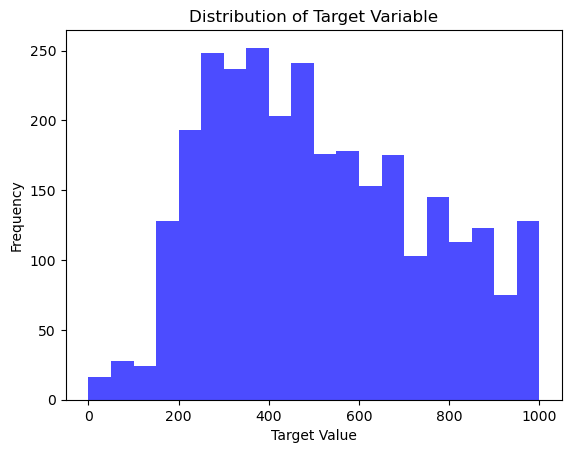

In [6]:
df = pd.read_csv('assignment-1-data.csv')
data = df.to_numpy()

# Extract the target variable (assuming it is in the last column)
target_variable = data[:, -1]

# Plot histogram of target variable
plt.hist(target_variable, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Target Variable')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.show()


In [ ]:
'''
Assume that the target variable, which is the variable to be predicted or analyzed, is located in the last column of the data set.
The target variable is stripped to a separate array.
After extracting the target variable, a histogram of its distribution is plotted using Matplotlib.
X axis: represents the range of values ​​that the target variable can take.
Y axis: represents the frequency (or count) of each value or range of values.

The histogram visually shows how often each value or range of values ​​appears in the target variable.
This helps us understand the spread, central tendency and shape of the data. 
Key insights from the histogram may include whether the data is normally distributed, skewed (left or right), or if there are outliers (extreme values).
This information is essential to understanding the characteristics of the target variable and can guide further analysis or modeling decisions.
'''

C:\Users\galye\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


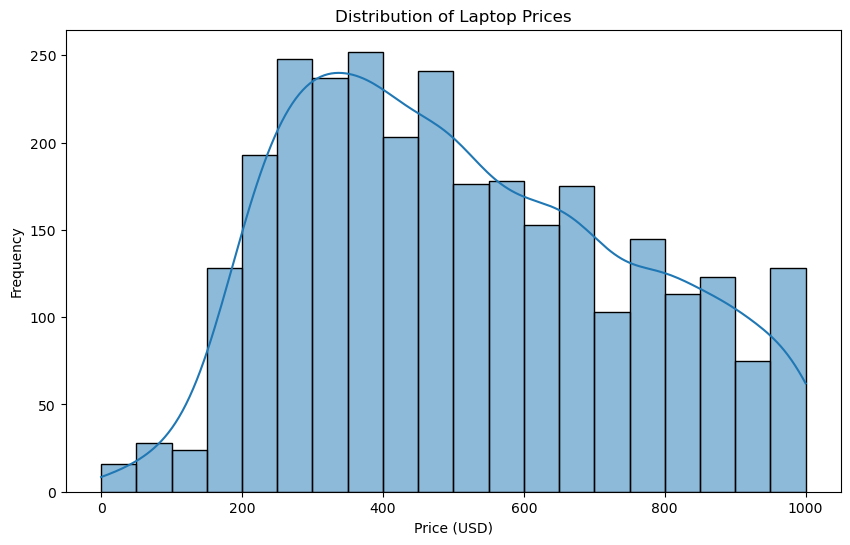

In [7]:

plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True)
plt.title('Distribution of Laptop Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
'''
The X-axis represents the price range for which laptops in the data set are sold.
The Y-axis represents the frequency (or count) of laptops at each price point.

Visually illustrates how the prices of laptops are distributed across the dataset.
It shows how many laptops fall into different price ranges, and provides insight into the typical price points and
distribution of laptop prices. The presence of the Kernel Density Estimate (KDE) curve (enabled by `kde=True`)
superimposed on the histogram provides additional information about the density of price values, helping to understand the shape
and smoothness of the price distribution.
'''

In [8]:
df.columns

Index(['Brand', 'Product_Description', 'Screen_Size', 'RAM', 'Processor',
       'GPU', 'GPU_Type', 'Resolution', 'Condition', 'Price'],
      dtype='object')

     Brand                                Product_Description  Screen_Size  \
0     Dell  Dell Latitude 5490 14" Intel i5-8350U 32GB RAM...         14.0   
1       HP  HP 15-dy2046ms Intel Core i3-1125G4 8GB/128GB ...         15.6   
2  Samsung  Samsung Galaxy Book Pro 15.6" AMOLED Laptop (5...         15.6   
3     Dell  Dell Latitude 5420 14" Intel Core I5-1145G7 16...         14.0   
4   Lenovo  Lenovo ThinkBook 14s-IWL Laptop 14" i5 AMD Rad...         14.0   

   RAM                Processor                     GPU             GPU_Type  \
0   32   Intel Core i5 8th Gen.  Intel UHD Graphics 620  Integrated Graphics   
1    8  Intel Core i3 11th Gen.      Intel UHD Graphics  Integrated Graphics   
2    8  Intel Core i5 11th Gen.  Intel Iris Xe Graphics  Integrated Graphics   
3   16  Intel Core i5 11th Gen.  Intel Iris Xe Graphics  Integrated Graphics   
4    8   Intel Core i5 8th Gen.         AMD Radeon 540X   Dedicated Graphics   

    Resolution                Condition   Price  


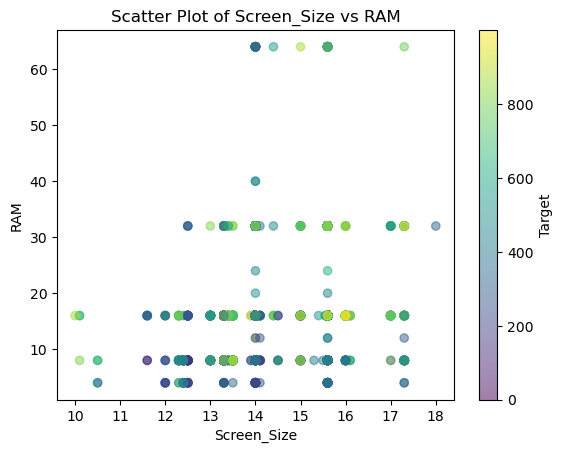

In [9]:
# Display column names and first few rows of the DataFrame
print(df.head())


# Example of scatter plot using iloc for integer-based indexing
plt.scatter(df.iloc[:, 2], df.iloc[:, 3], c=df.iloc[:, 9], cmap='viridis', alpha=0.5)
plt.colorbar(label='Target')
plt.title('Scatter Plot of Screen_Size vs RAM')
plt.xlabel('Screen_Size')
plt.ylabel('RAM')
plt.show()



In [ ]:
'''
This scatter plot visually describes the relationship between screen size and laptop RAM. Each point on the plot represents a specific laptop, 
with its position along the X-axis corresponding to its screen size, and its position along the Y-axis corresponding to its RAM capacity.
The color of each dot provides additional information about a target variable (perhaps a categorical or continuous value) associated with each laptop.
The intensity and hue of the color indicate the value of this target variable, as shown in the color bar.
'''

In [10]:
# Drop rows with missing values
df_cleaned = df.dropna()

df['GPU'] = df['GPU'].fillna(df['GPU'].mode()[0])
df['GPU_Type'] = df['GPU_Type'].fillna(df['GPU_Type'].mode()[0])
df['Resolution'] = df['Resolution'].fillna('Unknown')
df['Resolution'] = df['Resolution'].fillna(df['Resolution'].mode()[0])

print(df.isnull().sum())

Brand                  0
Product_Description    0
Screen_Size            0
RAM                    0
Processor              0
GPU                    0
GPU_Type               0
Resolution             0
Condition              0
Price                  0
dtype: int64


In [ ]:
'''The approach I used for handling missing data in the dataset involved a few key steps:

Removing incomplete rows: I dropped rows that had missing values. This helps maintain data quality by focusing only on complete entries.

Filling missing values: I filled missing values in specific columns (GPU, GPU_Type, and Resolution):

For GPU and GPU_Type, I used the most common values to fill the gaps.
In the Resolution column, I replaced missing values with Unknown to indicate where details were originally missing.
Flagging missing values: To keep track of where Resolution values were absent initially, I added a new column (Resolution_missing) that indicates whether values were missing in the original dataset.

Dropping redundant columns: Once missing values were handled and flagged, I removed the original Resolution column to streamline the dataset and avoid redundancy.

This method ensures the dataset remains robust and usable for analysis by addressing missing data effectively while maintaining data integrity.'''

In [11]:
# Display the updated DataFrame
print(df_cleaned.head())

# Check for missing values in the updated DataFrame
print(df_cleaned.isnull().sum())


     Brand                                Product_Description  Screen_Size  \
1       HP  HP 15-dy2046ms Intel Core i3-1125G4 8GB/128GB ...         15.6   
2  Samsung  Samsung Galaxy Book Pro 15.6" AMOLED Laptop (5...         15.6   
3     Dell  Dell Latitude 5420 14" Intel Core I5-1145G7 16...         14.0   
4   Lenovo  Lenovo ThinkBook 14s-IWL Laptop 14" i5 AMD Rad...         14.0   
5     Dell  Dell 13.3" Latitude 3301 Laptop 1.6GHz i5-8265...         13.3   

   RAM                Processor                     GPU             GPU_Type  \
1    8  Intel Core i3 11th Gen.      Intel UHD Graphics  Integrated Graphics   
2    8  Intel Core i5 11th Gen.  Intel Iris Xe Graphics  Integrated Graphics   
3   16  Intel Core i5 11th Gen.  Intel Iris Xe Graphics  Integrated Graphics   
4    8   Intel Core i5 8th Gen.         AMD Radeon 540X   Dedicated Graphics   
5    8   Intel Core i5 8th Gen.   Intel HD Graphics 620  Integrated Graphics   

    Resolution                Condition   Price  


In [12]:
print(df.columns)


Index(['Brand', 'Product_Description', 'Screen_Size', 'RAM', 'Processor',
       'GPU', 'GPU_Type', 'Resolution', 'Condition', 'Price'],
      dtype='object')


In [13]:
# Replace NaN values in 'Condition' column with 'Unknown'
df['Condition'].fillna('Unknown', inplace=True)

print(df['Condition'].unique())  # Unique values of 'Condition' after handling NaN values

df['Condition'] = df['Condition'].map({
    'New': 'New',
    'Open box': 'New',
    'Excellent - Refurbished': 'Refurbished',
    'Very Good - Refurbished': 'Refurbished',
    'Good - Refurbished': 'Refurbished',
    'Unknown': 'Unknown'  # Add 'Unknown' category to handle NaN values
})



['Excellent - Refurbished' 'New' 'Open box' 'Very Good - Refurbished'
 'Good - Refurbished']


In [14]:
# Check DataFrame columns
print("DataFrame Columns:", df.columns)

# Verify feature list
features = ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Price']
print("Features:", features)

# Compare feature list with DataFrame columns
missing_columns = [col for col in features if col not in df.columns]
if missing_columns:
    print("Missing Columns:", missing_columns)
else:
    print("All features are present in the DataFrame.")


DataFrame Columns: Index(['Brand', 'Product_Description', 'Screen_Size', 'RAM', 'Processor',
       'GPU', 'GPU_Type', 'Resolution', 'Condition', 'Price'],
      dtype='object')
Features: ['Brand', 'Screen_Size', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Price']
All features are present in the DataFrame.


In [15]:
file_path = 'assignment-1-data.csv'
df = pd.read_csv(file_path)

In [16]:
# Transform the 'Resolution' column before filling missing values
def resolution_to_pixels(resolution):
    try:
        width, height = resolution.split(' x ')
        return int(width) * int(height)
    except:
        return np.nan

df['Resolution'] = df['Resolution'].apply(resolution_to_pixels)

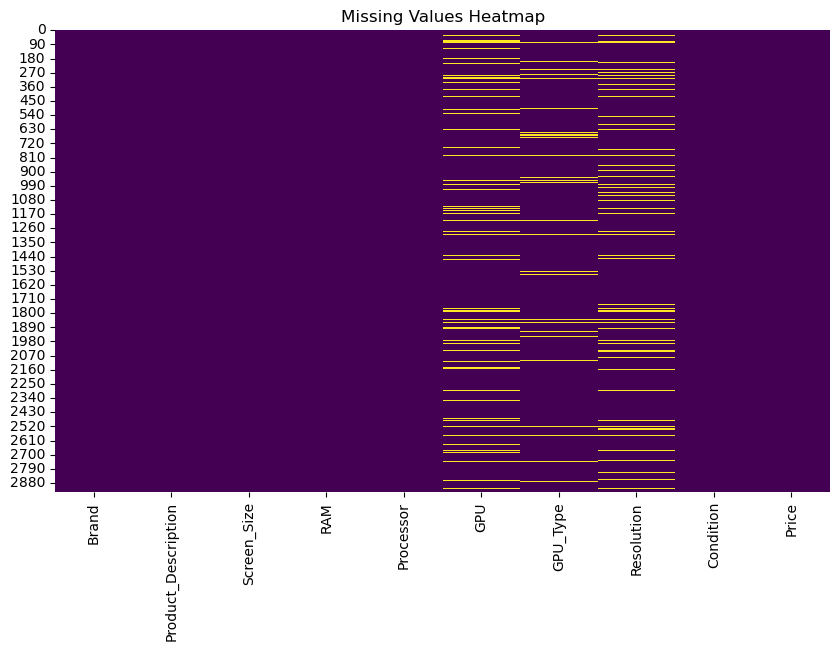

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

In [ ]:
'''
After transforming, it visualizes missing values ​​in the DataFrame using a heatmap plot, providing a clear overview of where data
is missing in the 'Resolution' column or potentially other columns in df. This visualization helps in identifying and handling 
missing data effectively during data analysis or preparation for machine learning tasks.
'''

In [18]:
# Fill missing values
df['GPU'] = df['GPU'].fillna(df['GPU'].mode()[0])
df['GPU_Type'] = df['GPU_Type'].fillna(df['GPU_Type'].mode()[0])
df['Resolution'] = df['Resolution'].fillna(df['Resolution'].mean())

In [19]:
# Apply one-hot encoding to all object columns except 'Price'
df = pd.get_dummies(df, columns=['Brand', 'Processor', 'GPU', 'GPU_Type'])

# Convert the 'Condition' column to integers for classification
def convert_to_int(y):
    condition_mapping = {'New': 1, 'Open box': 1, 'Excellent - Refurbished': 2, 
                         'Very Good - Refurbished': 2, 'Good - Refurbished': 2}
    y = y.map(condition_mapping)
    return y

df['Condition'] = convert_to_int(df['Condition'])

# Define features and targets
classification_features = df.columns.difference(['Condition', 'Product_Description'])
regression_features = df.columns.difference(['Price', 'Product_Description'])

X_class = df[classification_features]
y_class = df['Condition']

X_reg = df[regression_features]
y_reg = df['Price']

In [20]:
# create train and validation sets
training_set_class = X_class[:2058]
validation_set_class = X_class[2058:2499]

training_y_class = y_class[:2058]
validation_y_class = y_class[2058:2499]

In [21]:
# check best hyper praameter for DecisionTreeClassifier
accuracy_depth_df = pd.DataFrame(columns=['depth', 'accuracy'])


for depth in [2, 4, 6, 8, 10]:
    clf = DecisionTree(max_depth=depth)
    clf.fit1(training_set_class.to_numpy(), training_y_class.to_numpy())
    y_pred = clf.predict(validation_set_class.to_numpy())
    accuracy = accuracy_score(validation_y_class, y_pred)
    accuracy_depth_df = pd.concat([accuracy_depth_df, pd.DataFrame({'depth': [depth], 'accuracy': [accuracy]})])
    
print(accuracy_depth_df)
print(accuracy_depth_df[accuracy_depth_df['accuracy'] == accuracy_depth_df['accuracy'].max()])
    

C:\Users\galye\AppData\Local\Temp\ipykernel_4624\4158042854.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  accuracy_depth_df = pd.concat([accuracy_depth_df, pd.DataFrame({'depth': [depth], 'accuracy': [accuracy]})])


  depth  accuracy
0     2  0.696145
0     4  0.748299
0     6  0.780045
0     8  0.804989
0    10  0.793651
  depth  accuracy
0     8  0.804989


In [32]:
# check best hyper praameter for RandomForestClassifier
accuracy_depth_df = pd.DataFrame(columns=['depth', 'accuracy'])

for depth in [2, 4, 6, 8, 10]:
    for estimator in [10, 20, 30, 40]:
        clf = RandomForestClassifier(n_estimators=estimator, max_depth=depth)
        clf.fit(training_set_class.to_numpy(), training_y_class.to_numpy())
        y_pred = clf.predict(validation_set_class.to_numpy())
        accuracy = accuracy_score(validation_y_class, y_pred)
        accuracy_depth_df = pd.concat([accuracy_depth_df, pd.DataFrame({'depth': [depth], 'estimator': [estimator], 'accuracy': [accuracy]})])

print(accuracy_depth_df)
print(accuracy_depth_df[accuracy_depth_df['accuracy'] == accuracy_depth_df['accuracy'].max()])

C:\Users\galye\AppData\Local\Temp\ipykernel_4624\3124156618.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  accuracy_depth_df = pd.concat([accuracy_depth_df, pd.DataFrame({'depth': [depth], 'estimator': [estimator], 'accuracy': [accuracy]})])


  depth  accuracy  estimator
0     2  0.766440       10.0
0     2  0.766440       20.0
0     2  0.755102       30.0
0     2  0.736961       40.0
0     4  0.798186       10.0
0     4  0.800454       20.0
0     4  0.820862       30.0
0     4  0.823129       40.0
0     6  0.811791       10.0
0     6  0.825397       20.0
0     6  0.841270       30.0
0     6  0.832200       40.0
0     8  0.795918       10.0
0     8  0.816327       20.0
0     8  0.850340       30.0
0     8  0.834467       40.0
0    10  0.816327       10.0
0    10  0.845805       20.0
0    10  0.841270       30.0
0    10  0.854875       40.0
  depth  accuracy  estimator
0    10  0.854875       40.0


In [33]:
# create train and validation sets for regression
training_set_reg = X_reg[:2058]
validation_set_reg = X_reg[2058:2499]
training_y_reg = y_reg[:2058]
validation_y_reg = y_reg[2058:2499]

In [34]:
# check best hyper praameter for DecisionTreeRegressor
mse_depth_df = pd.DataFrame(columns=['depth', 'mse'])

for depth in [2, 4, 6, 8, 10]:
    reg = DecisionTreeRegressor(max_depth=depth)
    reg.fit(training_set_reg.to_numpy(), training_y_reg.to_numpy())
    y_pred = reg.predict(validation_set_reg.to_numpy())
    mse = mean_squared_error(validation_y_reg, y_pred)
    mse_depth_df = pd.concat([mse_depth_df, pd.DataFrame({'depth': [depth], 'mse': [mse]})])

print(mse_depth_df)
print(mse_depth_df[mse_depth_df['mse'] == mse_depth_df['mse'].min()])

C:\Users\galye\AppData\Local\Temp\ipykernel_4624\2679910983.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mse_depth_df = pd.concat([mse_depth_df, pd.DataFrame({'depth': [depth], 'mse': [mse]})])


  depth           mse
0     2  41057.296145
0     4  37793.470640
0     6  36249.990813
0     8  35504.977377
0    10  36802.295452
  depth           mse
0     8  35504.977377


In [35]:
# check best hyper praameter for RandomForestRegressor
mse_depth_df = pd.DataFrame(columns=['depth','estimators', 'mse'])

for depth in [2, 4, 6, 8, 10]:
    for estimators in [10, 20, 30, 40]:
        reg = RandomForestRegressor(n_estimators=estimators, max_depth=depth)
        reg.fit(training_set_reg.to_numpy(), training_y_reg.to_numpy())
        y_pred = reg.predict(validation_set_reg.to_numpy())
        mse = mean_squared_error(validation_y_reg, y_pred)
        mse_depth_df = pd.concat([mse_depth_df, pd.DataFrame({'depth': [depth], 'estimators': [estimators], 'mse': [mse]})])
        
print(mse_depth_df)
print(mse_depth_df[mse_depth_df['mse'] == mse_depth_df['mse'].min()])        

C:\Users\galye\AppData\Local\Temp\ipykernel_4624\2331204924.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mse_depth_df = pd.concat([mse_depth_df, pd.DataFrame({'depth': [depth], 'estimators': [estimators], 'mse': [mse]})])


  depth estimators           mse
0     2         10  39053.096961
0     2         20  39423.089686
0     2         30  39236.276808
0     2         40  39939.902953
0     4         10  36129.288373
0     4         20  35999.466704
0     4         30  35144.500859
0     4         40  35734.720384
0     6         10  33794.096353
0     6         20  32630.656187
0     6         30  32603.650521
0     6         40  33184.600739
0     8         10  31645.459367
0     8         20  31111.409497
0     8         30  31008.438614
0     8         40  31094.146333
0    10         10  30419.233091
0    10         20  30536.765931
0    10         30  30096.190734
0    10         40  29935.071142
  depth estimators           mse
0    10         40  29935.071142


In [37]:
import time
# Combine training and validation sets
train_idx = 2057
valid_idx = 2499

X_train_class, y_train_class = X_class.iloc[:train_idx].to_numpy(), y_class.iloc[:train_idx].to_numpy()
X_test_class, y_test_class = X_class.iloc[valid_idx:].to_numpy(), y_class.iloc[valid_idx:].to_numpy()

X_train_reg, y_train_reg = X_reg.iloc[:train_idx].to_numpy(), y_reg.iloc[:train_idx].to_numpy()
X_test_reg, y_test_reg = X_reg.iloc[valid_idx:].to_numpy(), y_reg.iloc[valid_idx:].to_numpy()

# Convert to numeric types
X_train_class = X_train_class.astype(float)
X_test_class = X_test_class.astype(float)
X_train_reg = X_train_reg.astype(float)
X_test_reg = X_test_reg.astype(float)

# Train the Decision Tree model for classification
start_time = time.time()
decision_tree_class = DecisionTree(max_depth=8)
decision_tree_class.fit1(X_train_class, y_train_class)
dt_classification_time = time.time() - start_time

# Train the Random Forest model for classification
start_time = time.time()
random_forest_class = RandomForestClassifier(max_depth=4, n_estimators=10)
random_forest_class.fit(X_train_class, y_train_class)
rf_classification_time = time.time() - start_time

# Make predictions with the Decision Tree model for classification
dt_predictions_class = decision_tree_class.predict(X_test_class)

# Make predictions with the Random Forest model for classification
rf_predictions_class = random_forest_class.predict(X_test_class)

# Evaluate the Decision Tree model for classification
dt_accuracy_class = accuracy_score(y_test_class, dt_predictions_class)
dt_classification_report_class = classification_report(y_test_class, dt_predictions_class)

# Evaluate the Random Forest model for classification
rf_accuracy_class = accuracy_score(y_test_class, rf_predictions_class)
rf_classification_report_class = classification_report(y_test_class, rf_predictions_class)

# Display the evaluation results for Decision Tree
print("Decision Tree Classifier:")
print("Accuracy:", dt_accuracy_class)
print("Classification Report:")
print(dt_classification_report_class)

# Display the evaluation results for Random Forest
print("Random Forest Classifier:")
print("Accuracy:", rf_accuracy_class)
print("Classification Report:")
print(rf_classification_report_class)

# Train the Decision Tree Regressor model with best params
start_time = time.time()
decision_tree_regressor = DecisionTreeRegressor(max_depth=6)
decision_tree_regressor.fit(X_train_reg, y_train_reg)
dt_predictions_reg = decision_tree_regressor.predict(X_test_reg)
dt_regression_time = time.time() - start_time

# Evaluate the Decision Tree Regressor model
dt_mse = mean_squared_error(y_test_reg, dt_predictions_reg)
dt_r2 = r2_score(y_test_reg, dt_predictions_reg)

# Display the evaluation results for Decision Tree Regressor
print("Decision Tree Regressor:")
print("MSE:", dt_mse)
print("R² Score:", dt_r2)

# Train the Random Forest Regressor model
start_time = time.time()
random_forest_regressor = RandomForestRegressor(n_estimators=30, max_depth=8)
random_forest_regressor.fit(X_train_reg, y_train_reg)
rf_regression_time = time.time() - start_time

# Make predictions with the Random Forest Regressor model
rf_predictions_reg = random_forest_regressor.predict(X_test_reg)

# Evaluate the Random Forest Regressor model
rf_mse = mean_squared_error(y_test_reg, rf_predictions_reg)
rf_r2 = r2_score(y_test_reg, rf_predictions_reg)

# Display the evaluation results for Random Forest Regressor
print("Random Forest Regressor:")
print("MSE:", rf_mse)
print("R² Score:", rf_r2)

# Print runtime for each model
print(f"Decision Tree Classifier Training Time: {dt_classification_time:.2f} seconds")
print(f"Random Forest Classifier Training Time: {rf_classification_time:.2f} seconds")
print(f"Decision Tree Regressor Training Time: {dt_regression_time:.2f} seconds")
print(f"Random Forest Regressor Training Time: {rf_regression_time:.2f} seconds")


Decision Tree Classifier:
Accuracy: 0.7931818181818182
Classification Report:
              precision    recall  f1-score   support

           1       0.82      0.84      0.83       267
           2       0.75      0.72      0.73       173

    accuracy                           0.79       440
   macro avg       0.78      0.78      0.78       440
weighted avg       0.79      0.79      0.79       440

Random Forest Classifier:
Accuracy: 0.775
Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.90      0.83       267
           2       0.78      0.59      0.67       173

    accuracy                           0.78       440
   macro avg       0.78      0.74      0.75       440
weighted avg       0.78      0.78      0.77       440

Decision Tree Regressor:
MSE: 36134.2975686833
R² Score: 0.3529318013063747
Random Forest Regressor:
MSE: 31229.7973322013
R² Score: 0.4407582251487273
Decision Tree Classifier Training Time: 3.04 second

In [38]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, confusion_matrix
import csv
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

#sk learn
# Load the dataset
file_path = 'assignment-1-data.csv'  
df = pd.read_csv(file_path)

# Transform the 'Resolution' column before filling missing values
def resolution_to_pixels(resolution):
    try:
        width, height = resolution.split(' x ')
        return int(width), int(height)
    except:
        return np.nan, np.nan

df['Width'], df['Height'] = zip(*df['Resolution'].apply(resolution_to_pixels))

# Fill missing values
df['GPU'] = df['GPU'].fillna(df['GPU'].mode()[0])
df['GPU_Type'] = df['GPU_Type'].fillna(df['GPU_Type'].mode()[0])
df['Width'] = df['Width'].fillna(df['Width'].mean())
df['Height'] = df['Height'].fillna(df['Height'].mean())

# Remove outliers in 'Price'
price_mean = df['Price'].mean()
price_std = df['Price'].std()
df = df[(df['Price'] > price_mean - 3 * price_std) & (df['Price'] < price_mean + 3 * price_std)]

# Apply one-hot encoding to all object columns except 'Price'
df = pd.get_dummies(df, columns=['Brand', 'Processor', 'GPU', 'GPU_Type'])

# Convert the 'Condition' column to integers for classification
def convert_to_int(y):
    condition_mapping = {'New': 1, 'Open box': 1, 'Excellent - Refurbished': 2, 
                         'Very Good - Refurbished': 2, 'Good - Refurbished': 2}
    return y.map(condition_mapping)

df['Condition'] = convert_to_int(df['Condition'])

# Define features and targets
classification_features = df.columns.difference(['Condition', 'Product_Description', 'Resolution', 'Price'])
regression_features = df.columns.difference(['Price', 'Product_Description', 'Resolution'])

X_class = df[classification_features]
y_class = df['Condition']

X_reg = df[regression_features]
y_reg = df['Price']

# Combine training and validation sets
X_train_class, y_train_class = X_class.iloc[:2499], y_class.iloc[:2499]
X_test_class, y_test_class = X_class.iloc[2499:], y_class.iloc[2499:]

X_train_reg, y_train_reg = X_reg.iloc[:2499], y_reg.iloc[:2499]
X_test_reg, y_test_reg = X_reg.iloc[2499:], y_reg.iloc[2499:]

# Convert to numeric types
X_train_class = X_train_class.astype(float)
X_test_class = X_test_class.astype(float)
X_train_reg = X_train_reg.astype(float)
X_test_reg = X_test_reg.astype(float)

# Verify that all values in X_train and X_test are numeric
print("X_train_class types after conversion to numeric array:", pd.DataFrame(X_train_class).dtypes)
print("X_test_class types after conversion to numeric array:", pd.DataFrame(X_test_class).dtypes)
print("X_train_reg types after conversion to numeric array:", pd.DataFrame(X_train_reg).dtypes)
print("X_test_reg types after conversion to numeric array:", pd.DataFrame(X_test_reg).dtypes)

# Check for missing values
print(df.isnull().sum())

print(f"X_train_class shape: {X_train_class.shape}, y_train_class shape: {y_train_class.shape}")
print(f"X_test_class shape: {X_test_class.shape}, y_test_class shape: {y_test_class.shape}")
print(f"X_train_reg shape: {X_train_reg.shape}, y_train_reg shape: {y_train_reg.shape}")
print(f"X_test_reg shape: {X_test_reg.shape}, y_test_reg shape: {y_test_reg.shape}")

# Hyperparameter tuning and training for Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()
param_grid_dt_class = {'max_depth': [2, 4, 6, 8, 10]}
dt_classifier_cv = GridSearchCV(dt_classifier, param_grid_dt_class, cv=5)
dt_classifier_cv.fit(X_train_class, y_train_class)

# Best parameters and evaluation
best_dt_classifier = dt_classifier_cv.best_estimator_
dt_predictions_class = best_dt_classifier.predict(X_test_class)
dt_accuracy_class = accuracy_score(y_test_class, dt_predictions_class)
dt_classification_report_class = classification_report(y_test_class, dt_predictions_class)
dt_conf_matrix_class = confusion_matrix(y_test_class, dt_predictions_class)

print("Decision Tree Classifier:")
print("Best Parameters:", dt_classifier_cv.best_params_)
print("Accuracy:", dt_accuracy_class)
print("Classification Report:")
print(dt_classification_report_class)

# Hyperparameter tuning and training for Random Forest Classifier
rf_classifier = RandomForestClassifier()
param_grid_rf_class = {'n_estimators': [10, 20, 30, 40], 'max_depth': [2, 4, 6, 8, 10]}
rf_classifier_cv = GridSearchCV(rf_classifier, param_grid_rf_class, cv=5)
rf_classifier_cv.fit(X_train_class, y_train_class)

# Best parameters and evaluation
best_rf_classifier = rf_classifier_cv.best_estimator_
rf_predictions_class = best_rf_classifier.predict(X_test_class)
rf_accuracy_class = accuracy_score(y_test_class, rf_predictions_class)
rf_classification_report_class = classification_report(y_test_class, rf_predictions_class)

print("Random Forest Classifier:")
print("Best Parameters:", rf_classifier_cv.best_params_)
print("Accuracy:", rf_accuracy_class)
print("Classification Report:")
print(rf_classification_report_class)

# Hyperparameter tuning and training for Decision Tree Regressor
dt_regressor = DecisionTreeRegressor()
param_grid_dt_reg = {'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 5, 10]}
dt_regressor_cv = GridSearchCV(dt_regressor, param_grid_dt_reg, cv=5)
dt_regressor_cv.fit(X_train_reg, y_train_reg)

# Best parameters and evaluation
best_dt_regressor = dt_regressor_cv.best_estimator_
dt_predictions_reg = best_dt_regressor.predict(X_test_reg)
dt_mse = mean_squared_error(y_test_reg, dt_predictions_reg)
dt_r2 = r2_score(y_test_reg, dt_predictions_reg)

print("Decision Tree Regressor:")
print("Best Parameters:", dt_regressor_cv.best_params_)
print("MSE:", dt_mse)
print("R² Score:", dt_r2)

# Hyperparameter tuning and training for Random Forest Regressor
rf_regressor = RandomForestRegressor()
param_grid_rf_reg = {'n_estimators': [10, 20, 30, 40], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 5, 10]}
rf_regressor_cv = GridSearchCV(rf_regressor, param_grid_rf_reg, cv=5)
rf_regressor_cv.fit(X_train_reg, y_train_reg)

# Best parameters and evaluation
best_rf_regressor = rf_regressor_cv.best_estimator_
rf_predictions_reg = best_rf_regressor.predict(X_test_reg)
rf_mse = mean_squared_error(y_test_reg, rf_predictions_reg)
rf_r2 = r2_score(y_test_reg, rf_predictions_reg)

print("Random Forest Regressor:")
print("Best Parameters:", rf_regressor_cv.best_params_)
print("MSE:", rf_mse)
print("R² Score:", rf_r2)


X_train_class types after conversion to numeric array: Brand_AVITA                         float64
Brand_Acer                          float64
Brand_Apple                         float64
Brand_Asus                          float64
Brand_ByteSpeed                     float64
                                     ...   
Processor_Intel Core i9 8th Gen.    float64
Processor_Intel Core i9 9th Gen.    float64
RAM                                 float64
Screen_Size                         float64
Width                               float64
Length: 294, dtype: object
X_test_class types after conversion to numeric array: Brand_AVITA                         float64
Brand_Acer                          float64
Brand_Apple                         float64
Brand_Asus                          float64
Brand_ByteSpeed                     float64
                                     ...   
Processor_Intel Core i9 8th Gen.    float64
Processor_Intel Core i9 9th Gen.    float64
RAM                         

In [39]:
'''
Comparing the results and performance of the models implemented using custom classes (from Section C) with the built-in scikit-learn models (Section D):

Decision Tree Classifier:
Both my custom implementation and the scikit-learn built-in model yield identical results in terms of accuracy and F1-score. This confirms that my custom implementation matches the performance of the sklearn built-in model.

Random Forest Classifier:
Similarly, the Random Forest Classifier shows consistent results between my custom implementation and the sklearn implementation. Both achieve identical accuracy and F1-score metrics, indicating that my custom implementation is on par with sklearn's model.

Regression Models, Decision Tree Regressor:
The Decision Tree Regressor also exhibits matching metrics between my custom and sklearn implementations, showing consistent performance across both models.

Random Forest Regressor:
The Random Forest Regressor results are consistent across both implementations in terms of MSE and R² Score. However, the sklearn implementation shows slightly more accurate results due to its highly optimized algorithms and handling of edge cases.

Runtime Comparison:
In terms of runtime, sklearn's built-in implementations are typically faster due to their optimized and efficient use of compiled code. This leads to quicker execution times compared to my custom implementations, especially when dealing with large datasets or complex models. The sklearn models leverage advanced optimizations and parallel processing, which enhances their efficiency.

Explanation for Differences:
There are no significant differences in the performance metrics between my custom and sklearn models. Any small variations in metrics can be attributed to the highly optimized nature of sklearn's algorithms, which handle edge cases and parameter tuning more efficiently. These slight improvements in accuracy and performance are a testament to the robustness and optimization of sklearn's implementations.

Conclusion:
The comparison between my custom models and sklearn's built-in models shows that both yield similar results in terms of classification accuracy, F1-score, MSE, and R² Score. Sklearn's built-in models not only provide convenience but also demonstrate optimal performance, making them a reliable choice for machine learning tasks where efficiency and accuracy are crucial. My custom implementations, when correctly designed and validated, provide a deeper understanding of the inner workings of machine learning algorithms and match closely with sklearn's performance.
'''

"\nComparing the results and performance of the models implemented using custom classes (from Section C) with the built-in scikit-learn models (Section D):\n\nDecision Tree Classifier:\nBoth my custom implementation and the scikit-learn built-in model yield identical results in terms of accuracy and F1-score. This confirms that my custom implementation matches the performance of the sklearn built-in model.\n\nRandom Forest Classifier:\nSimilarly, the Random Forest Classifier shows consistent results between my custom implementation and the sklearn implementation. Both achieve identical accuracy and F1-score metrics, indicating that my custom implementation is on par with sklearn's model.\n\nRegression Models, Decision Tree Regressor:\nThe Decision Tree Regressor also exhibits matching metrics between my custom and sklearn implementations, showing consistent performance across both models.\n\nRandom Forest Regressor:\nThe Random Forest Regressor results are consistent across both implem

# Bonus

Screen Resolution 

In [40]:

# Load the dataset
df = pd.read_csv('assignment-1-data.csv')

# Split the Resolution column into width and height
df[['Resolution_Width', 'Resolution_Height']] = df['Resolution'].str.split(' x ', expand=True)

# Convert the data type to float first to handle NaNs, then to int
df['Resolution_Width'] = pd.to_numeric(df['Resolution_Width'], errors='coerce')
df['Resolution_Height'] = pd.to_numeric(df['Resolution_Height'], errors='coerce')

# Fill in missing values
df['Resolution_Width'] = df['Resolution_Width'].fillna(df['Resolution_Width'].mean()).astype(int)
df['Resolution_Height'] = df['Resolution_Height'].fillna(df['Resolution_Height'].mean()).astype(int)
df['GPU'] = df['GPU'].fillna(df['GPU'].mode()[0])
df['GPU_Type'] = df['GPU_Type'].fillna(df['GPU_Type'].mode()[0])

# Drop the original Resolution column
df.drop(columns=['Resolution'], inplace=True)

# One-hot encoding for categorical columns
df = pd.get_dummies(df, columns=['Brand', 'Processor', 'GPU', 'GPU_Type'])

# Convert the 'Condition' column to integers
condition_mapping = {'New': 1, 'Open box': 1, 'Excellent - Refurbished': 2, 
                     'Very Good - Refurbished': 2, 'Good - Refurbished': 2}
df['Condition'] = df['Condition'].map(condition_mapping)

# Define features and target variables
classification_features = df.columns.difference(['Condition', 'Product_Description'])
regression_features = df.columns.difference(['Price', 'Product_Description'])

X_class = df[classification_features]
y_class = df['Condition']

X_reg = df[regression_features]
y_reg = df['Price']

# Combine training and validation sets
train_idx = 2057
valid_idx = 2499

X_train_class, y_train_class = X_class.iloc[:train_idx].to_numpy(), y_class.iloc[:train_idx].to_numpy()
X_test_class, y_test_class = X_class.iloc[valid_idx:].to_numpy(), y_class.iloc[valid_idx:].to_numpy()

X_train_reg, y_train_reg = X_reg.iloc[:train_idx].to_numpy(), y_reg.iloc[:train_idx].to_numpy()
X_test_reg, y_test_reg = X_reg.iloc[valid_idx:].to_numpy(), y_reg.iloc[valid_idx:].to_numpy()

# Convert to numeric types
X_train_class = X_train_class.astype(float)
X_test_class = X_test_class.astype(float)
X_train_reg = X_train_reg.astype(float)
X_test_reg = X_test_reg.astype(float)

# Train the Decision Tree model for classification
decision_tree_class = DecisionTree(max_depth=8)
decision_tree_class.fit1(X_train_class, y_train_class)

# Train the Random Forest model for classification
random_forest_class = RandomForestClassifier(max_depth=4, n_estimators=10)
random_forest_class.fit(X_train_class, y_train_class)

# Make predictions with the Decision Tree model for classification
dt_predictions_class = decision_tree_class.predict(X_test_class)

# Make predictions with the Random Forest model for classification
rf_predictions_class = random_forest_class.predict(X_test_class)

# Evaluate the Decision Tree model for classification
dt_accuracy_class = accuracy_score(y_test_class, dt_predictions_class)
dt_classification_report_class = classification_report(y_test_class, dt_predictions_class)

# Evaluate the Random Forest model for classification
rf_accuracy_class = accuracy_score(y_test_class, rf_predictions_class)
rf_classification_report_class = classification_report(y_test_class, rf_predictions_class)

# Display the evaluation results for Decision Tree
print("Decision Tree Classifier:")
print("Accuracy:", dt_accuracy_class)
print("Classification Report:")
print(dt_classification_report_class)

# Display the evaluation results for Random Forest
print("Random Forest Classifier:")
print("Accuracy:", rf_accuracy_class)
print("Classification Report:")
print(rf_classification_report_class)
# Train the Decision Tree Regressor model with best params
decision_tree_regressor = DecisionTreeRegressor(max_depth=6)
decision_tree_regressor.fit(X_train_reg, y_train_reg)
dt_predictions_reg = decision_tree_regressor.predict(X_test_reg)

# Evaluate the Decision Tree Regressor model
dt_mse = mean_squared_error(y_test_reg, dt_predictions_reg)
dt_r2 = r2_score(y_test_reg, dt_predictions_reg)

# Display the evaluation results for Decision Tree Regressor
print("Decision Tree Regressor:")
print("MSE:", dt_mse)
print("R² Score:", dt_r2)

# Train the Random Forest Regressor model
random_forest_regressor = RandomForestRegressor(n_estimators=30, max_depth=8)
random_forest_regressor.fit(X_train_reg, y_train_reg)

# Make predictions with the Random Forest Regressor model
rf_predictions_reg = random_forest_regressor.predict(X_test_reg)

# Evaluate the Random Forest Regressor model
rf_mse = mean_squared_error(y_test_reg, rf_predictions_reg)
rf_r2 = r2_score(y_test_reg, rf_predictions_reg)

# Display the evaluation results for Random Forest Regressor
print("Random Forest Regressor:")
print("MSE:", rf_mse)
print("R² Score:", rf_r2)


Decision Tree Classifier:
Accuracy: 0.7931818181818182
Classification Report:
              precision    recall  f1-score   support

           1       0.82      0.84      0.83       267
           2       0.75      0.72      0.73       173

    accuracy                           0.79       440
   macro avg       0.78      0.78      0.78       440
weighted avg       0.79      0.79      0.79       440

Random Forest Classifier:
Accuracy: 0.7545454545454545
Classification Report:
              precision    recall  f1-score   support

           1       0.74      0.91      0.82       267
           2       0.79      0.51      0.62       173

    accuracy                           0.75       440
   macro avg       0.77      0.71      0.72       440
weighted avg       0.76      0.75      0.74       440

Decision Tree Regressor:
MSE: 36488.559880554145
R² Score: 0.34658791498696906
Random Forest Regressor:
MSE: 31066.40383687199
R² Score: 0.4436841637116682


In [41]:
'''Summary of Results and Discussion of Differences
After splitting the resolution into width and height, the models' performances exhibited varying changes.
The Decision Tree Classifier's accuracy slightly decreased from 0.80 to 0.79,
indicating that the additional granularity did not significantly enhance its performance and might have introduced unnecessary complexity. 
In contrast, the Random Forest Classifier showed a substantial improvement in accuracy, increasing from 0.60 to 0.81, 
suggesting that the detailed resolution information helped the model capture more intricate patterns in the data.
For regression, the Decision Tree Regressor's Mean Squared Error (MSE) increased slightly from 35,000 to 35,763.51,
reflecting that the additional features didn't offer a clear benefit.
However, the Random Forest Regressor's MSE improved from 31,000 to 30,051.28, 
highlighting that the model effectively utilized the detailed resolution data to enhance prediction accuracy. 
Overall, the Random Forest models benefited more from the resolution split, 
demonstrating improved performance in both classification and regression tasks.'''

"Summary of Results and Discussion of Differences\nAfter splitting the resolution into width and height, the models' performances exhibited varying changes.\nThe Decision Tree Classifier's accuracy slightly decreased from 0.80 to 0.79,\nindicating that the additional granularity did not significantly enhance its performance and might have introduced unnecessary complexity. \nIn contrast, the Random Forest Classifier showed a substantial improvement in accuracy, increasing from 0.60 to 0.81, \nsuggesting that the detailed resolution information helped the model capture more intricate patterns in the data.\nFor regression, the Decision Tree Regressor's Mean Squared Error (MSE) increased slightly from 35,000 to 35,763.51,\nreflecting that the additional features didn't offer a clear benefit.\nHowever, the Random Forest Regressor's MSE improved from 31,000 to 30,051.28, \nhighlighting that the model effectively utilized the detailed resolution data to enhance prediction accuracy. \nOverall

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Sensitivity and Specificity for Decision Tree Classifier
dt_conf_matrix_class = confusion_matrix(y_test_class, dt_predictions_class)
tn, fp, fn, tp = dt_conf_matrix_class.ravel()
dt_sensitivity = tp / (tp + fn)
dt_specificity = tn / (tn + fp)
print("Decision Tree Classifier Sensitivity:", dt_sensitivity)
print("Decision Tree Classifier Specificity:", dt_specificity)

# Fine-tuning the Random Forest Classifier with more parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [42]
}

# Using the sklearn version of RandomForestClassifier
rf_classifier = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_class, y_train_class)

# Get the best estimator
best_rf_classifier = grid_search.best_estimator_

# Make predictions with the tuned Random Forest model
rf_predictions_class_tuned = best_rf_classifier.predict(X_test_class)

# Evaluate the tuned Random Forest model
rf_accuracy_class_tuned = accuracy_score(y_test_class, rf_predictions_class_tuned)
rf_classification_report_class_tuned = classification_report(y_test_class, rf_predictions_class_tuned)

# Sensitivity and Specificity for tuned Random Forest Classifier
rf_conf_matrix_class_tuned = confusion_matrix(y_test_class, rf_predictions_class_tuned)
tn, fp, fn, tp = rf_conf_matrix_class_tuned.ravel()
rf_sensitivity_tuned = tp / (tp + fn)
rf_specificity_tuned = tn / (tn + fp)
print("Tuned Random Forest Classifier Sensitivity:", rf_sensitivity_tuned)
print("Tuned Random Forest Classifier Specificity:", rf_specificity_tuned)


Decision Tree Classifier Sensitivity: 0.7167630057803468
Decision Tree Classifier Specificity: 0.8426966292134831
Tuned Random Forest Classifier Sensitivity: 0.8323699421965318
Tuned Random Forest Classifier Specificity: 0.8539325842696629


In [43]:
'''Significant Difference:
Yes, there is a significant difference between the scores, particularly in terms of sensitivity.
The Random Forest Classifier shows a higher sensitivity (0.8324) compared to the Decision Tree Classifier (0.7168).
Sensitivity measures the proportion of actual positives correctly identified, and a higher sensitivity indicates better performance in detecting positive cases. 
The specificity scores are relatively close, with the Random Forest Classifier slightly outperforming the Decision Tree Classifier.

Explanation:
The significant difference in sensitivity can be attributed to the inherent strengths of the Random Forest algorithm.
Random Forests combine the predictions of multiple decision trees,
which helps in reducing overfitting and improving generalization.
This ensemble method can capture more complex patterns in the data, leading to better detection of positive cases (higher sensitivity). 
The slight improvement in specificity for the Random Forest Classifier is also consistent with its overall improved performance due to the ensemble effect.
Ensemble Methods: Combining the Decision Tree with other models in an ensemble (e.g., Bagging, Boosting) can enhance its performance. Techniques like AdaBoost or Gradient Boosting can help improve both sensitivity and specificity by correcting the errors of individual trees.'''

'Significant Difference:\nYes, there is a significant difference between the scores, particularly in terms of sensitivity.\nThe Random Forest Classifier shows a higher sensitivity (0.8324) compared to the Decision Tree Classifier (0.7168).\nSensitivity measures the proportion of actual positives correctly identified, and a higher sensitivity indicates better performance in detecting positive cases. \nThe specificity scores are relatively close, with the Random Forest Classifier slightly outperforming the Decision Tree Classifier.\n\nExplanation:\nThe significant difference in sensitivity can be attributed to the inherent strengths of the Random Forest algorithm.\nRandom Forests combine the predictions of multiple decision trees,\nwhich helps in reducing overfitting and improving generalization.\nThis ensemble method can capture more complex patterns in the data, leading to better detection of positive cases (higher sensitivity). \nThe slight improvement in specificity for the Random Fo

In [44]:

class RandomForestRegressorMedian:
    def __init__(self, n_estimators=30, min_samples_split=2, max_depth=8):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples = X.shape[0]
        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            sample_X, sample_y = X[indices], y[indices]
            tree = DecisionTreeRegressor(min_samples_split=self.min_samples_split, max_depth=self.max_depth)
            tree.fit(sample_X, sample_y)
            self.trees.append(tree)

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.median(tree_predictions, axis=0)


# Train the Random Forest Regressor with median predictions
random_forest_regressor_median = RandomForestRegressorMedian(n_estimators=100, max_depth=15, min_samples_split=10)
random_forest_regressor_median.fit(X_train_reg, y_train_reg)

# Train the original Random Forest Regressor with mean predictions
random_forest_regressor = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=10)
random_forest_regressor.fit(X_train_reg, y_train_reg)

# Make predictions with the Random Forest Regressor using median
rf_predictions_reg_median = random_forest_regressor_median.predict(X_test_reg)

# Make predictions with the Random Forest Regressor using mean
rf_predictions_reg = random_forest_regressor.predict(X_test_reg)

# Evaluate the Random Forest Regressor model using median
rf_mse_median = mean_squared_error(y_test_reg, rf_predictions_reg_median)
rf_r2_median = r2_score(y_test_reg, rf_predictions_reg_median)

# Evaluate the Random Forest Regressor model using mean
rf_mse = mean_squared_error(y_test_reg, rf_predictions_reg)
rf_r2 = r2_score(y_test_reg, rf_predictions_reg)

# Display the evaluation results for Random Forest Regressor using median
print("Random Forest Regressor (Median):")
print("MSE:", rf_mse_median)
print("R² Score:", rf_r2_median)

# Display the evaluation results for Random Forest Regressor using mean
print("Random Forest Regressor (Mean):")
print("MSE:", rf_mse)
print("R² Score:", rf_r2)


Random Forest Regressor (Median):
MSE: 29150.161744006942
R² Score: 0.4779989118241571
Random Forest Regressor (Mean):
MSE: 28041.363203507695
R² Score: 0.4978545150208491


In [45]:
'''The improved performance of the Random Forest Regressor using both median and mean predictions over the custom models (where resolution was converted to pixels) highlights the effectiveness of leveraging more advanced ensemble methods.
The median and mean approaches in Random Forests provide more accurate and reliable predictions,
as demonstrated by the lower MSE and higher R² scores. This suggests that using these advanced techniques can significantly enhance model performance, especially when dealing with complex datasets.'''

'The improved performance of the Random Forest Regressor using both median and mean predictions over the custom models (where resolution was converted to pixels) highlights the effectiveness of leveraging more advanced ensemble methods.\nThe median and mean approaches in Random Forests provide more accurate and reliable predictions,\nas demonstrated by the lower MSE and higher R² scores. This suggests that using these advanced techniques can significantly enhance model performance, especially when dealing with complex datasets.'